In [1]:
import numpy as np
import matplotlib.pyplot as plt

**<font size=5>Layers Class</font>**

In [2]:
#輸入資料的tensor及產生對應的權重零矩陣
class Parameter():
    def __init__(self, tensor):
        self.tensor = tensor
        self.gradient = np.zeros_like(self.tensor)

In [3]:
#training過程:計算forward, backward計算權重, 更新權重
#定義forward用於傳遞輸入的參數並於output計算完之後更新權重
class Layer:
    def __init__(self):
        self.parameters = []

    #經過forward傳遞輸入
    def forward(self, X):
        return X, lambda D: D

    #儲存參數
    def build_param(self, tensor):
        param = Parameter(tensor)
        self.parameters.append(param)
        return param
 
    #更新權重
    def update(self, optimizer):
        for param in self.parameters: 
            optimizer.update(param)

In [4]:
#將output計算結果回傳
class Linear(Layer):
      def __init__(self, inputs, outputs):
        super().__init__()
        self.weights = self.build_param(np.random.randn(inputs, outputs) * np.sqrt(1 / inputs))
        self.bias = self.build_param(np.zeros(outputs))
  
      def forward(self, X):
        def backward(D):
            self.weights.gradient += X.T @ D
            self.bias.gradient += D.sum(axis=0)
            return D @ self.weights.tensor.T
        return X @ self.weights.tensor + self.bias.tensor, backward

In [5]:
#當有很多層，將連續的輸出儲存於一個list，該list以相反順序使用以獲得第一層輸入的權重
class Sequential(Layer):
      def __init__(self, *layers):
        super().__init__()
        self.layers = layers
        for layer in layers:
            self.parameters.extend(layer.parameters)
    
      def forward(self, X):
        backprops = []
        Y = X
        for layer in self.layers:
            Y, backprop = layer.forward(Y)
            backprops.append(backprop)
        def backward(D):
            for backprop in reversed(backprops):
                D = backprop(D)
            return D
        return Y, backward

**<font size=5>Activations</font>**

In [6]:
#定義激活函數relu
class ReLu(Layer):
    def forward(self, X):
        mask = X > 0
        return X * mask, lambda D: D * mask

In [7]:
#定義激活函數sigmoid
class Sigmoid(Layer):
    def forward(self, X):
        S = 1 / (1 + np.exp(-X))
        def backward(D):
            return D * S * (1 - S)
        return S, backward

**<font size=5>Loss functions</font>**

In [8]:
#定義loss function"mse"
def mse_loss(Y_, Y):
    diff = Y_ - Y.reshape(Y_.shape)
    return np.square(diff).mean(), 2 * diff / len(diff)

**<font size=5>Optimizers</font>**

In [9]:
#定義優化器sgd
class SGDOptimizer():
    def __init__(self, lr=0.1):
        self.lr = lr

    def update(self, param):
        param.tensor -= self.lr * param.gradient
        param.gradient.fill(0)

**<font size=5>Training Loop</font>**

In [10]:
#定義training loop    
class Learner():
    def __init__(self, model, loss, optimizer):
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
    
    #進行預測
    def predict(self, X, Y):
        Y_, backward = self.model.forward(X)
        result = np.zeros_like(Y_)
        for i in range(Y_.shape[0]):
            result[i, np.argmax(Y_[i])] = 1
        result = Y_
        return result

    # 這裡計算準確率    
    def accuracy(self, X, Y):
        pre = self.predict(X, Y)
        result = np.where(np.argmax(Y, axis=0)==np.argmax(pre, axis=0), 1, 0)
        #result = np.where(pre>=0.5, 1, 0)
        #result = np.where(abs(Y - pre) <0.1 , 1, 0)
        acc = np.mean(result)
        return acc
    
    def fit_batch(self, X, Y):
        Y_, backward = self.model.forward(X)
        L, D = self.loss(Y_, Y)
        backward(D)
        self.model.update(self.optimizer)
        return L
    
    def fit(self, X, Y, epochs, batch_sizes):
        losses = []
        acc = []
        fitparam = {}
        for epoch in range(epochs):
            p = np.random.permutation(len(X))
            L = 0
            for i in range(0, len(X), batch_sizes):
                X_batch = X[p[i:i + batch_sizes]]
                Y_batch = Y[p[i:i + batch_sizes]]
                L += self.fit_batch(X_batch, Y_batch)
            losses.append(L)
            accu = self.accuracy(X, Y)
            acc.append(accu)
            if epoch == epochs - 2:
                global is_last_epoch
                is_last_epoch = 1
            print("epoch:%d, Accuracy: %f, Loss: %f"%(epoch, accu, L))
        fitparam['loss'] = losses
        fitparam['accuracy'] = acc
        return fitparam

**<font size=5>產生train及test資料</font>**

In [11]:
#產生2維都是正數的矩陣
int_array1 = np.random.randint(0, 100, (150, 2))

#產生其中一維是負數的矩陣
int_array2 = np.random.randint(0, 100, (150, 2))
int_array3 = np.random.randint(0, 100, (150, 2))
for i in range(150):
    int_array2[i][0] = np.random.randint(-100, 0)
    int_array3[i][1] = np.random.randint(-100, 0)

#產生2維都是負數的矩陣
int_array4 = np.random.randint(-100, 0, (150, 2))

In [12]:
#將前面的矩陣串接在一起組成訓練及測試資料集
#訓練及測試資料集數量皆為200
data_train = np.zeros((400, 2))
data_test = np.zeros((200, 2))
train_label = np.zeros((400, 1))
test_label = np.zeros((200, 1))

for i in range(4):
    if i==0:
        for j in range(100):
            data_train[j] = int_array1[j]
            train_label[j] = '1000'
        for j in range(50):
            data_test[j] = int_array1[j+100]
            test_label[j] = '1000'
    if i==1:
        for j in range(100):
            data_train[j+100] = int_array2[j]
            train_label[j+100] = '0100'
        for j in range(50):
            data_test[j+50] = int_array2[j+100]
            test_label[j+50] = '0100'
    if i==2:
        for j in range(100):
            data_train[j+200] = int_array3[j]
            train_label[j+200] = '0010'
        for j in range(50):
            data_test[j+100] = int_array3[j+100]
            test_label[j+100] = '0010'
    if i==3:
        for j in range(100):
            data_train[j+300] = int_array4[j]
            train_label[j+300] = '0001'
        for j in range(50):
            data_test[j+150] = int_array4[j+100]
            test_label[j+150] = '0001'

<font size=5>資料標準化</font>

In [13]:
#定義zscore標準化函式
def zscore(x, axis=None):
    xmean = x.mean(axis=axis, keepdims=True)
    xstd = np.std(x, axis=axis, keepdims=True)
    zscore = (x-xmean)/xstd
    return zscore

In [14]:
#資料標準化
data_train = (data_train+100)/200
data_test = (data_test+100)/200
data_train = zscore(data_train, axis=0)
data_test = zscore(data_test, axis=0)

In [15]:
#label編碼
label_train_encode = np.zeros((400, 1))
label_test_encode = np.zeros((200, 1))
for i in range(4):
    if  i ==0:
        for j in range(100):
            label_train_encode[i] = 0.4
        for j in range(50):
            label_test_encode[i] = 0.4
    if  i ==1:
        for j in range(100):
            label_train_encode[i+100] = 0.5
        for j in range(50):
            label_test_encode[i+50] = 0.5
    if  i ==2:
        for j in range(100):
            label_train_encode[i+200] = 0.6
        for j in range(50):
            label_test_encode[i+100] = 0.6
    if  i ==3:
        for j in range(100):
            label_train_encode[i+300] = 0.7
        for j in range(50):
            label_test_encode[i+150] = 0.7


**<font size=5>Training Data</font>**

In [16]:
epochs = 100 #訓練回數
batch_size = 10 #batch_size
learning_rate = 0.01 #學習率
#hidden_neurons = 50 #隱藏層神經元數量

In [17]:
model = Learner(
    Sequential(
        Linear(2, 128), 
        Sigmoid(), 
        Linear(128, 256),
        Sigmoid(),
        Linear(256, 1),
        Sigmoid()
    ), 
    mse_loss, 
    SGDOptimizer(lr=learning_rate)
).fit(data_train, label_train_encode, epochs=epochs, batch_sizes=batch_size)

epoch:0, Accuracy: 0.000000, Loss: 2.512549
epoch:1, Accuracy: 0.000000, Loss: 0.448715
epoch:2, Accuracy: 0.000000, Loss: 0.293240
epoch:3, Accuracy: 0.000000, Loss: 0.236292
epoch:4, Accuracy: 0.000000, Loss: 0.207099
epoch:5, Accuracy: 0.000000, Loss: 0.189515
epoch:6, Accuracy: 0.000000, Loss: 0.177783
epoch:7, Accuracy: 0.000000, Loss: 0.169442
epoch:8, Accuracy: 0.000000, Loss: 0.163226
epoch:9, Accuracy: 0.000000, Loss: 0.158408
epoch:10, Accuracy: 0.000000, Loss: 0.154594
epoch:11, Accuracy: 0.000000, Loss: 0.151495
epoch:12, Accuracy: 0.000000, Loss: 0.148934
epoch:13, Accuracy: 0.000000, Loss: 0.146775
epoch:14, Accuracy: 0.000000, Loss: 0.144939
epoch:15, Accuracy: 0.000000, Loss: 0.143361
epoch:16, Accuracy: 0.000000, Loss: 0.141991
epoch:17, Accuracy: 0.000000, Loss: 0.140790
epoch:18, Accuracy: 0.000000, Loss: 0.139729
epoch:19, Accuracy: 0.000000, Loss: 0.138785
epoch:20, Accuracy: 0.000000, Loss: 0.137942
epoch:21, Accuracy: 0.000000, Loss: 0.137182
epoch:22, Accuracy: 

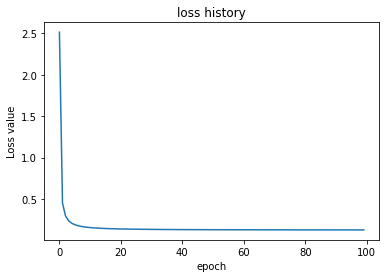

In [18]:
plt.plot(model['loss'])
plt.title('loss history')
plt.ylabel('Loss value')
plt.xlabel('epoch')
plt.show()

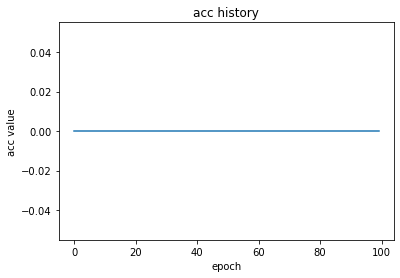

In [19]:
plt.plot(model['accuracy'])
plt.title('acc history')
plt.ylabel('acc value')
plt.xlabel('epoch')
plt.show()

**<font size=5>Predict</font>**

In [20]:
#輸出預測結果
Learner(
    Sequential(
        Linear(2, 128), 
        Sigmoid(), 
        Linear(128, 256),
        Sigmoid(),
        Linear(256, 1),
        Sigmoid()
    ), 
    mse_loss, 
    SGDOptimizer(lr=learning_rate)
).predict(data_test, label_test_encode)

array([[0.54423271],
       [0.54715354],
       [0.55365709],
       [0.53593362],
       [0.54920064],
       [0.52900121],
       [0.54484812],
       [0.53521534],
       [0.54403468],
       [0.53885104],
       [0.5325852 ],
       [0.54272307],
       [0.54844346],
       [0.55352786],
       [0.53614848],
       [0.55349332],
       [0.54962054],
       [0.54268458],
       [0.55173855],
       [0.54906066],
       [0.54224009],
       [0.55450386],
       [0.53959941],
       [0.53748483],
       [0.54306415],
       [0.54898998],
       [0.54926735],
       [0.55142889],
       [0.53458389],
       [0.53601315],
       [0.52960085],
       [0.54656866],
       [0.54204746],
       [0.55685578],
       [0.54434595],
       [0.54510191],
       [0.53147554],
       [0.54636208],
       [0.55562418],
       [0.54464922],
       [0.54099881],
       [0.5547406 ],
       [0.54979654],
       [0.54142647],
       [0.55175792],
       [0.54625119],
       [0.54552347],
       [0.529

In [21]:
#輸出正確率
Learner(
    Sequential(
        Linear(2, 128), 
        Sigmoid(), 
        Linear(128, 256),
        Sigmoid(),
        Linear(256, 1),
        Sigmoid()
    ), 
    mse_loss, 
    SGDOptimizer(lr=learning_rate)
).accuracy(data_test, label_test_encode)

0.0